In [472]:
import glob
import random

import numpy as np

from keyrover import *

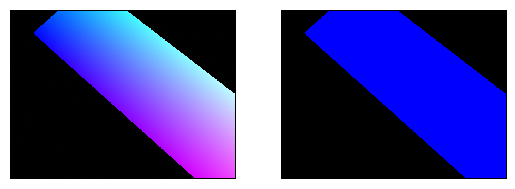

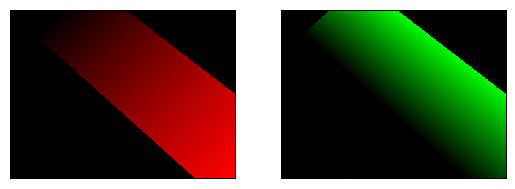

In [936]:
paths = glob.glob(f"blender/texcoords/*.png")
path = random.choice(paths)

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = img[:, :, 2] > 1
mask_indices = np.where(mask)

r, g, b = cv2.split(img)
r = r.astype("float")
g = g.astype("float")

z = np.zeros(r.shape)

imshow(img, np.stack([z, z, b]))
imshow(np.stack([r, z, z]), np.stack([z, g, z]))

In [937]:
drdy, drdx = map(lambda grad: grad[mask], np.gradient(r))
dgdy, dgdx = map(lambda grad: grad[mask], np.gradient(g))

drdx_mean = drdx[abs(drdx) < 10].mean()
drdy_mean = drdy[abs(drdy) < 10].mean()
dgdx_mean = dgdx[abs(dgdx) < 10].mean()
dgdy_mean = dgdy[abs(dgdy) < 10].mean()

J = np.array([[drdx_mean, drdy_mean], [dgdx_mean, dgdy_mean]])
v1, v2 = np.linalg.inv(J).T

print("∇r =", J[0])
print("∇g =", J[1])
print()
print("v1", v1)
print("v2", v2)

∇r = [     0.2554     0.24576]
∇g = [    0.66814    -0.80098]

v1 [      2.172      1.8118]
v2 [    0.66642    -0.69257]


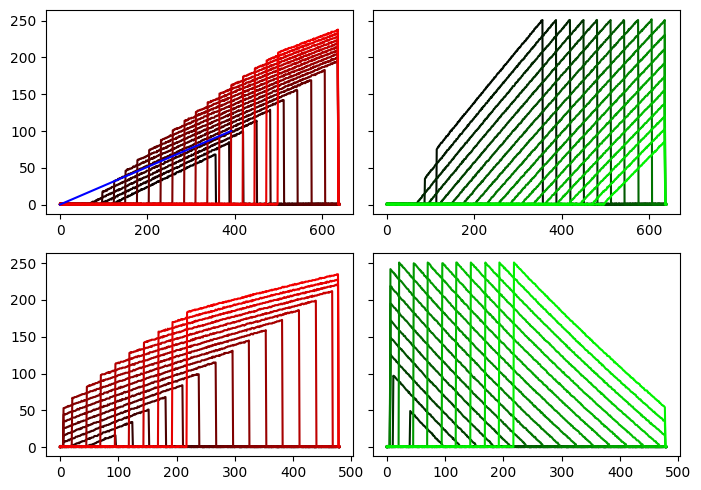

In [938]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5), sharey=True)

r_max = 0

for i in np.linspace(0, 480, 20, dtype="int", endpoint=False):
    line = r[i]
    if len(masked := line[mask[i]]) == 0:
        continue
    ax1.plot(line, c=(i / 480, 0, 0))

    line = g[i]
    ax2.plot(line, c=(0, i / 480, 0))

for i in np.linspace(0, 640, 20, dtype="int", endpoint=False):
    line = r[:, i]
    ax3.plot(line, c=(i / 640, 0, 0))

    line = g[:, i]
    ax4.plot(line, c=(0, i / 640, 0))
    
y = np.array([0, 100])
ax1.plot(y / drdx_mean, y, c="b")
    
plt.tight_layout()

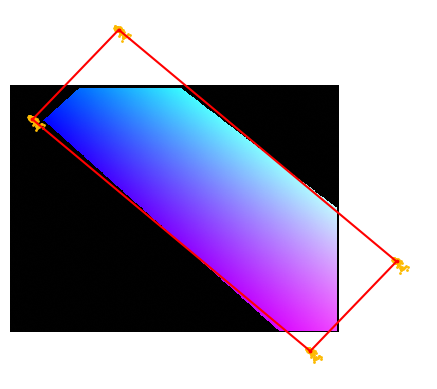

In [939]:
rand = np.random.randint(0, mask_indices[0].shape[0], size=100)
corners = {(0, 0): [], (0, 1): [], (1, 0): [], (1, 1): []}

for ref in zip(mask_indices[1][rand], mask_indices[0][rand]):
    ref_val = img[*ref[::-1]]
    
    dx, dy, _ = np.array([249, 252, 255]) - ref_val
    corners[(1, 1)].append(ref + dx * v1 + dy * v2)

    dx, dy, _ = np.array([249, 0, 255]) - ref_val
    corners[(1, 0)].append(ref + dx * v1 + dy * v2)

    dx, dy, _ = np.array([0, 0, 255]) - ref_val
    corners[(0, 0)].append(ref + dx * v1 + dy * v2)

    dx, dy, _ = np.array([0, 252, 255]) - ref_val
    corners[(0, 1)].append(ref + dx * v1 + dy * v2)

corners[(0, 0)] = np.array(corners[(0, 0)])
corners[(0, 1)] = np.array(corners[(0, 1)])
corners[(1, 0)] = np.array(corners[(1, 0)])
corners[(1, 1)] = np.array(corners[(1, 1)])

imshow(img)
plt.scatter(*corners[(0, 0)].T, color="#fcba03", s=1)
plt.scatter(*corners[(0, 1)].T, color="#fcba03", s=1)
plt.scatter(*corners[(1, 0)].T, color="#fcba03", s=1)
plt.scatter(*corners[(1, 1)].T, color="#fcba03", s=1)

corners[(0, 0)] = corners[(0, 0)].mean(axis=0)
corners[(0, 1)] = corners[(0, 1)].mean(axis=0)
corners[(1, 0)] = corners[(1, 0)].mean(axis=0)
corners[(1, 1)] = corners[(1, 1)].mean(axis=0)

plt.scatter(*corners[(0, 0)], color="red", s=3)
plt.scatter(*corners[(0, 1)], color="red", s=3)
plt.scatter(*corners[(1, 0)], color="red", s=3)
plt.scatter(*corners[(1, 1)], color="red", s=3)

quad = np.array([corners[(0, 0)], corners[(0, 1)], corners[(1, 1)], corners[(1, 0)], corners[(0, 0)]])
plt.plot(*quad.T, 'r-')